**Mushroom Classification: Safe to eat or deadly poison?**
<table align="left">
  <td>
    <a target="_blank" href="https://www.kaggle.com/code/filippodoldi/mushrooms-classification/edit/run/121143299"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

**Context**

Although this dataset was originally contributed to the UCI Machine Learning repository nearly 30 years ago, mushroom hunting (otherwise known as "shrooming") is enjoying new peaks in popularity. Learn which features spell certain death and which are most palatable in this dataset of mushroom characteristics. And how certain can your model be?

**Content**

This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

**Solution and results**

In this binary classification problem since the poisonus class is the positive class we aim to maximize recall in order to avoid false negatives, i.e. people getting poisoned by eating misclassiefied mushrooms. Due to the high number of nominal variables we solve the problem through random forests achieving a perfect classification on the test set with grid search cross validation.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Important-features-and-test-results" data-toc-modified-id="Important-features-and-test-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Important features and test results</a></span></li></ul></div>

# Preprocessing

In [10]:
import pandas as pd

df = pd.read_csv("/kaggle/input/mushroom-classification/mushrooms.csv")

Target Information: 

- classes: edible=e, poisonous=p

Attribute Information: 

- cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

- cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

- cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

- bruises: bruises=t,no=f

- odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

- gill-attachment: attached=a,descending=d,free=f,notched=n

- gill-spacing: close=c,crowded=w,distant=d

- gill-size: broad=b,narrow=n

- gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

- stalk-shape: enlarging=e,tapering=t

- stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

- stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

- stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

- stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

- stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

- veil-type: partial=p,universal=u

- veil-color: brown=n,orange=o,white=w,yellow=y

- ring-number: none=n,one=o,two=t

- ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

- spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

- population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

- habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

All our varibles are nominal, let's check their encoding and if there is some missing values.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

We don't have missing values, so we can proced to show some barplots of all the features divided by class (poisonus or edible):

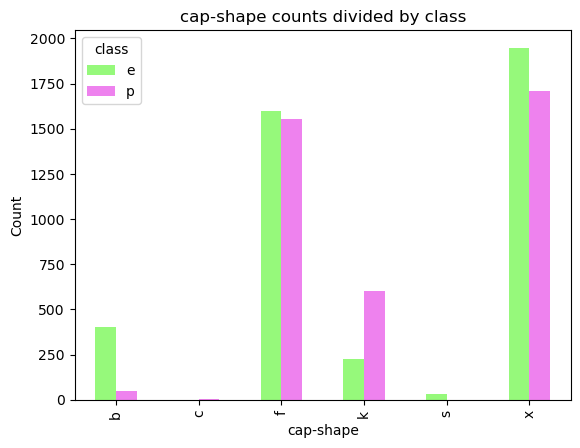

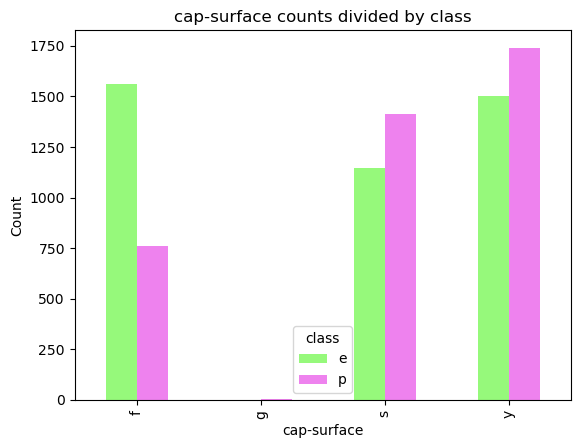

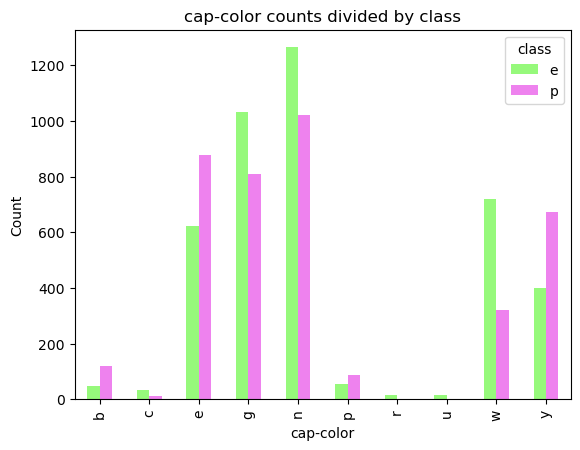

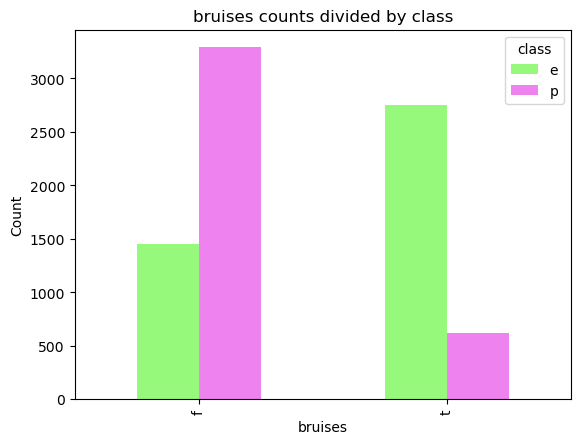

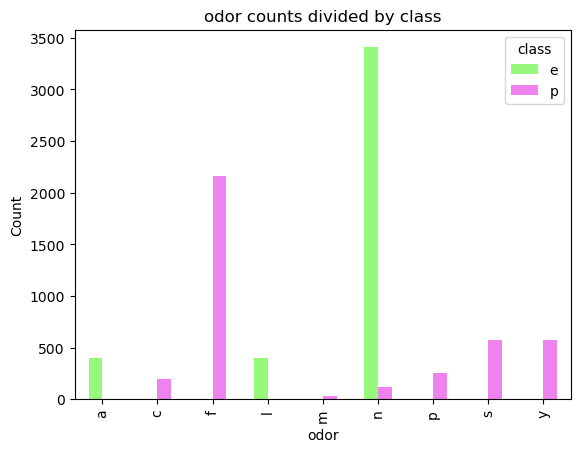

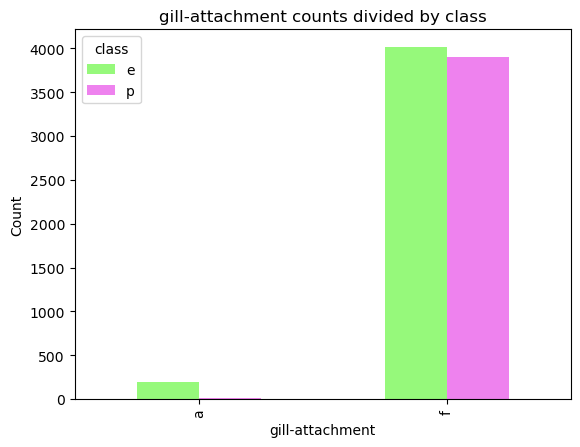

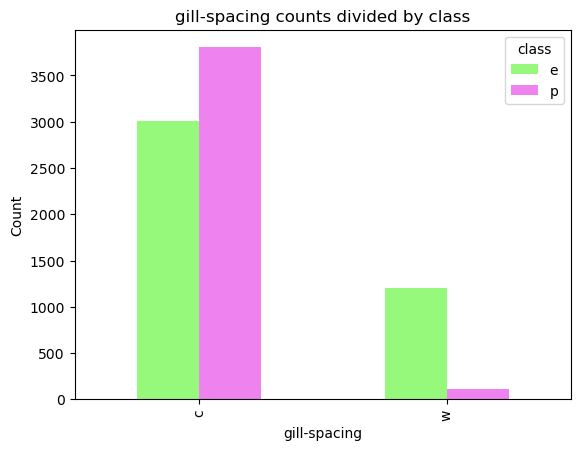

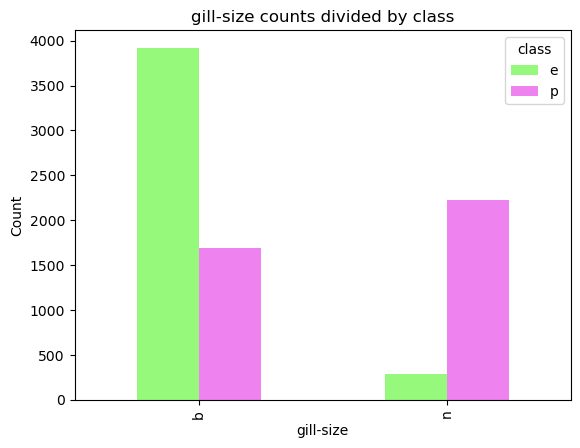

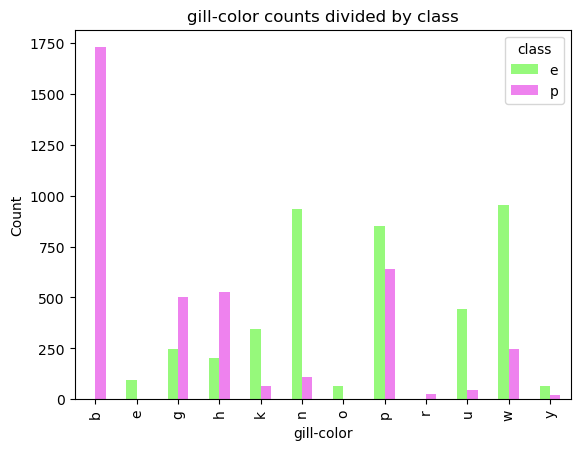

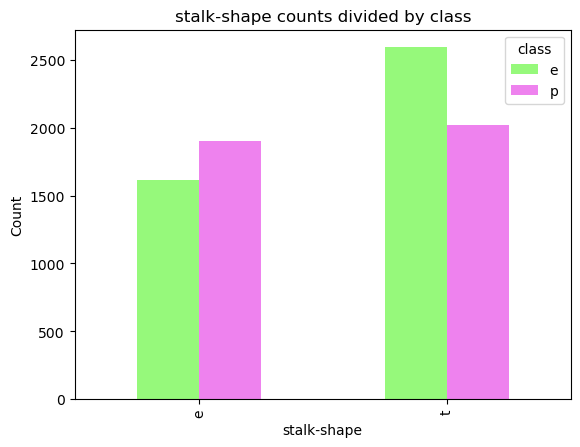

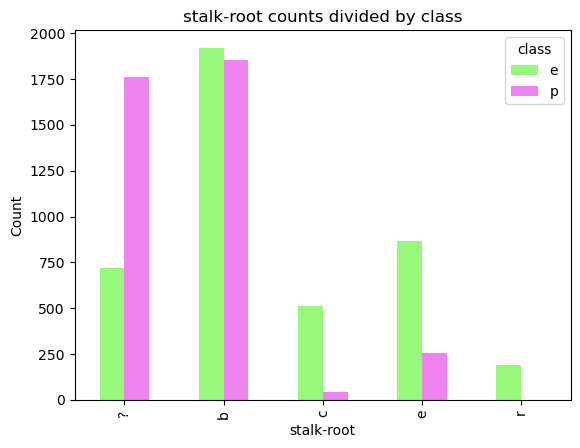

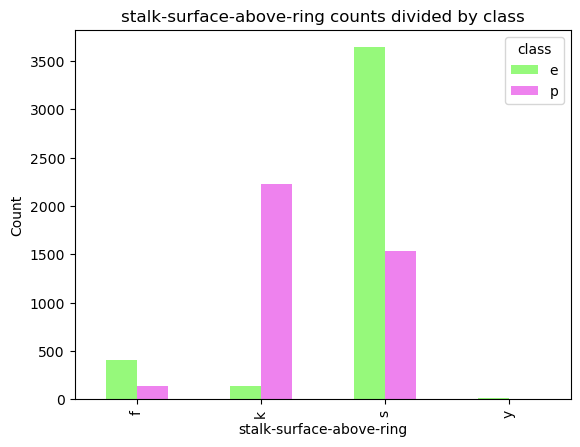

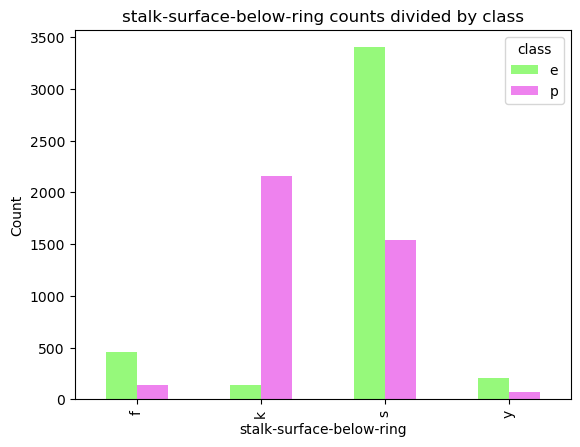

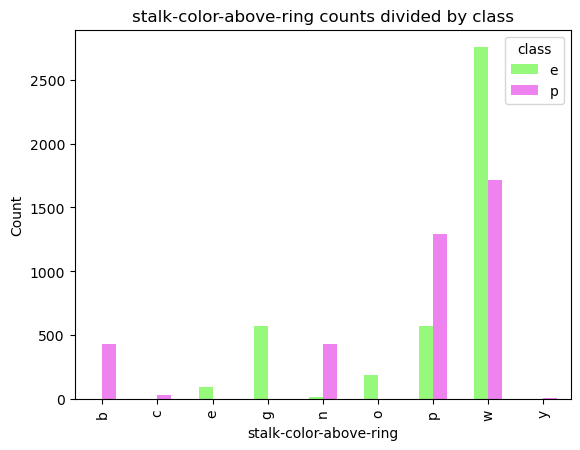

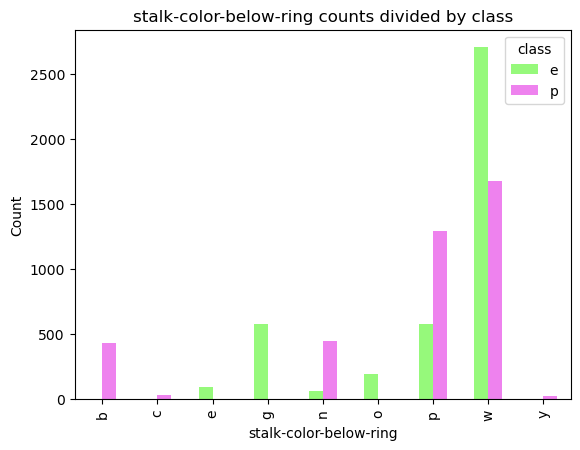

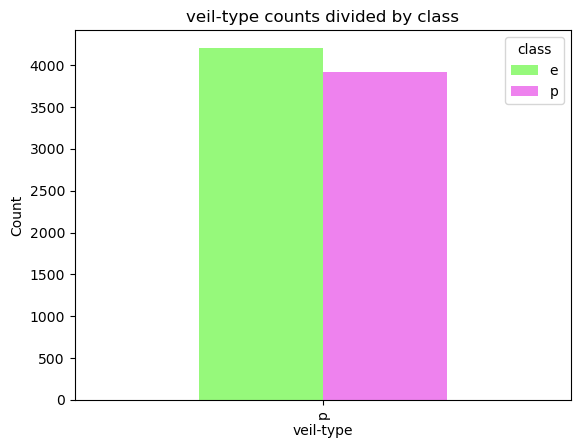

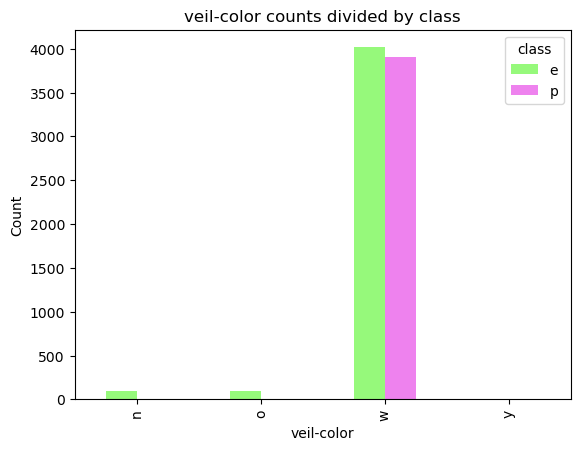

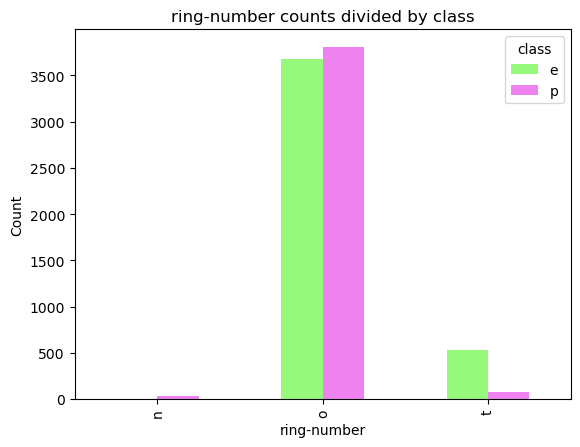

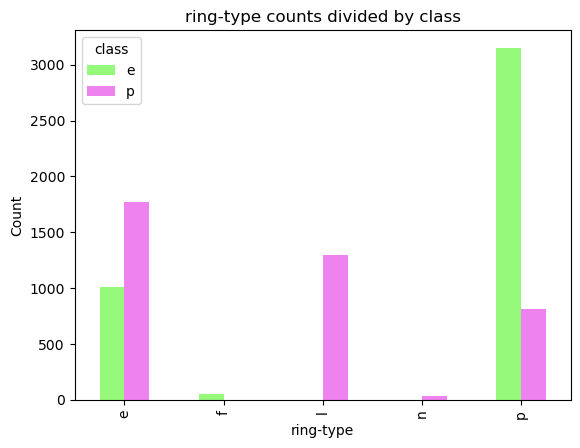

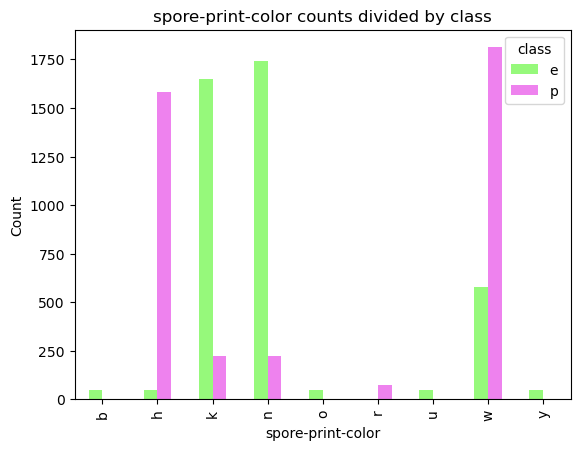

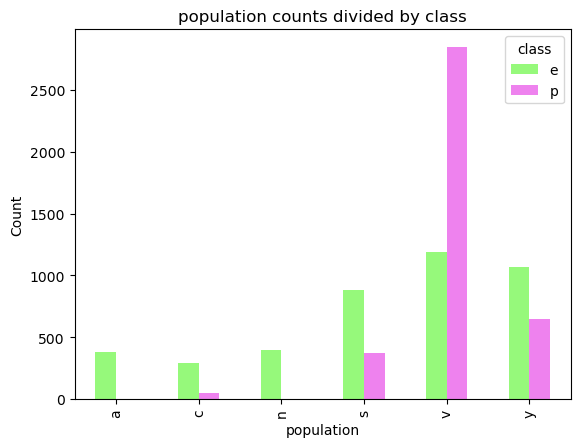

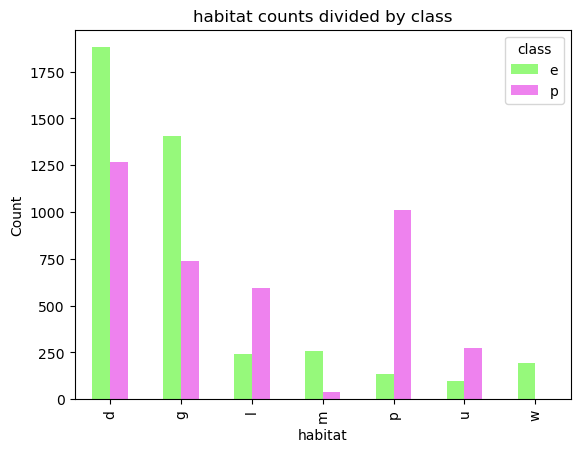

In [12]:
import matplotlib.pyplot as plt
import numpy as np

colors = {"p": "violet", "e": "#96f97b"}
for feature in df.columns[1:]:
    counts = df.groupby(feature)["class"].value_counts().unstack()
    
    ax = counts.plot(kind="bar", color=[colors[c] for c in counts.columns])
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.set_title(f'{feature} counts divided by class')
    plt.show()

We can see that a lot of categories are exclusive of one class, for example if we look at odor we notice that only 'n' = none is shared among the two classes; this types of divisions will be very impactful on the result of the final model.

Also we notice that the 'veil-type' column takes just one value 'p' so we discard it.

In [13]:
df = df.drop(columns = ["veil-type"])

# Random Forest Classifier

In order to speed up the process let's encode the letter as numbers, we will use an ordinal encoder even if we won't care about the numbers' order.

In [14]:
from sklearn.preprocessing import OrdinalEncoder

X = pd.DataFrame(OrdinalEncoder(dtype = int).fit_transform(df), columns = df.columns)

After encoding the poisonus class is assigned to be the positive class.

Now, since we have a lot of categorical variable with very different values we will avoid one-hot encoding using Random forests which can handle very well this type of nominal variables. So let's create the target and split the dataset before training the model:

In [15]:
from sklearn.model_selection import train_test_split

target = X["class"].copy()
X = X.drop(columns = ["class"]).copy()

rs = 10
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.3, random_state = rs)

Before training our random forest let's train and visualize a simple decision tree:

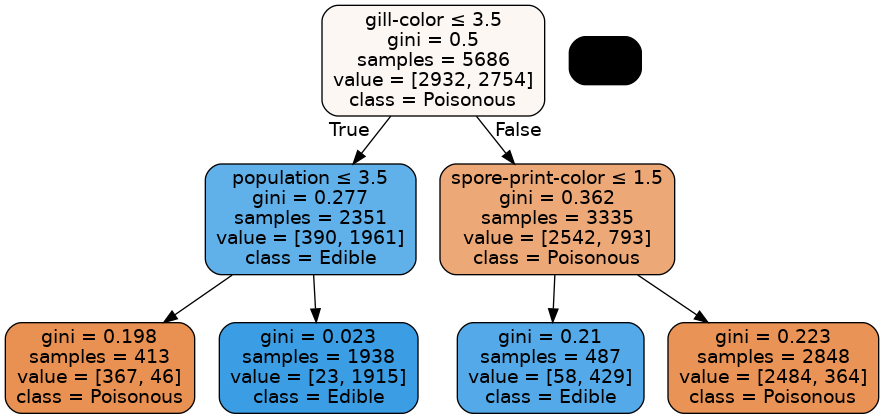

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from io import StringIO 
from IPython.display import Image  
import pydotplus

clf = DecisionTreeClassifier(max_depth = 2)
clf.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns, 
                class_names=["Poisonous", "Edible"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We notice that with this type of encoding our nominal variables are treated as ordinal, but we don't care about this since the algorithm simply chooses the split that maximizes the information gain by splitting different values of the categories. Yes we create a nonsense order, but we keep the dimensionality low.

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, max_depth = 10, max_features = 10,
                                 n_jobs=-1, random_state=rs)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10, max_leaf_nodes=16,
                       n_jobs=-1, random_state=10)

In [18]:
from sklearn.model_selection import cross_val_score
import numpy as np
score = cross_val_score(model, X_train, y_train, cv = 5, scoring = "recall")

print("mean_recall: ", np.mean(score))
print("recall_std: ", np.std(score))

mean_recall:  0.9952813067150637
recall_std:  0.0060302169603760935


We achieve sensational results even without tuning the hyperparameters. To achieve even better results let's use grid search:

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [100, 150, 200, 300], 
  'max_features': [10, 13, 16, 19],
  'max_leaf_nodes': [13, 16, 19],
  'max_depth': [8, 10, 12],
 },
 ]

grid_search = GridSearchCV(model, param_grid, cv=5, scoring = 'recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=10,
                                              max_leaf_nodes=16, n_jobs=-1,
                                              random_state=10),
             param_grid=[{'max_depth': [8, 10, 12],
                          'max_features': [10, 13, 16, 19],
                          'max_leaf_nodes': [13, 16, 19],
                          'n_estimators': [100, 150, 200, 300]}],
             scoring='recall')

Let's check the parameters and the score:

In [20]:
final_model = grid_search.best_estimator_ 

print(grid_search.best_params_ )

{'max_depth': 8, 'max_features': 10, 'max_leaf_nodes': 19, 'n_estimators': 100}


In [21]:
print(grid_search.best_score_ )

1.0


We achieved perfection, let's check its standard deviation through cross-validation:

In [22]:
recall = cross_val_score(final_model, X_train, y_train, cv = 5, scoring = "recall")

print("mean_recall: ", np.mean(recall))
print("recall_std: ", np.std(recall))

mean_recall:  1.0
recall_std:  0.0


Since we have maximized recall, let's check also the precision for completness:

In [23]:
precision = cross_val_score(final_model, X_train, y_train, cv = 5, scoring = "precision")

print("mean_precision: ", np.mean(precision))
print("precision_std: ", np.std(precision))

mean_precision:  1.0
precision_std:  0.0


This mean also that we have 100% accuracy.

# Important features and test results

Now let's look at the features that are the most meaningful in the prediction:

In [24]:
feature_importances = final_model.feature_importances_
feature_importances.round(1)

array([0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.1, 0.2, 0. , 0.1, 0. , 0. ,
       0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0. ])

In [25]:
indexes = feature_importances > 0.05
important_features = X.columns[indexes]

In [26]:
important_features

Index(['odor', 'gill-size', 'gill-color', 'stalk-root', 'ring-type',
       'spore-print-color', 'population'],
      dtype='object')

Let's see again the barplot of this important features:

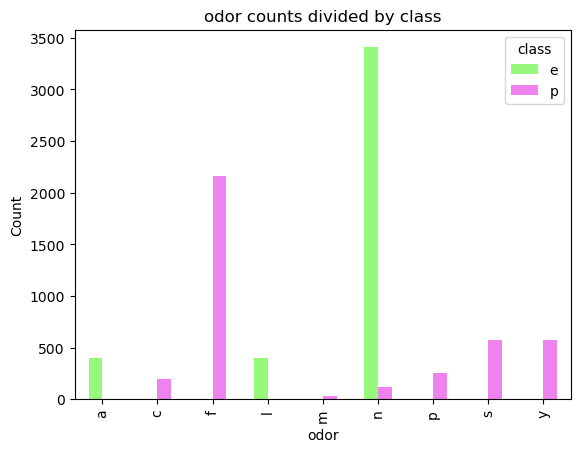

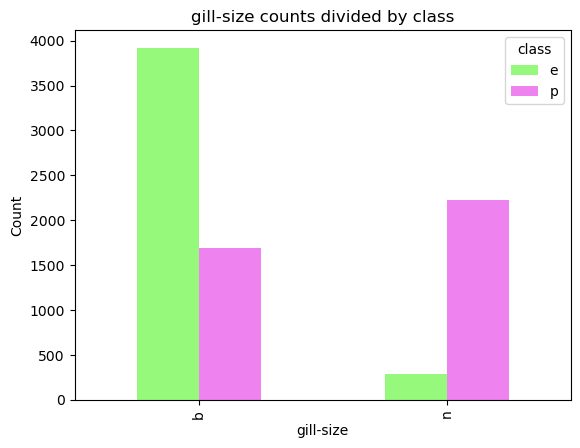

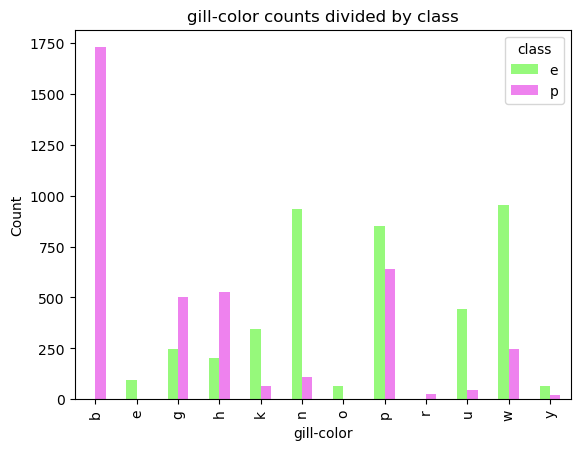

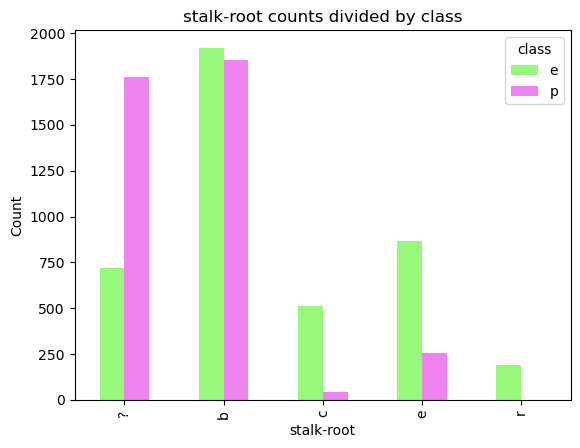

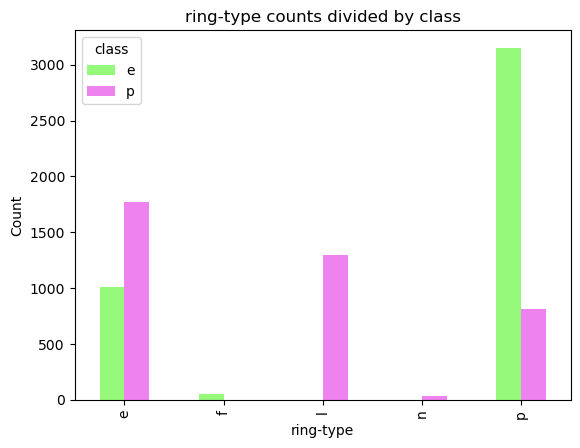

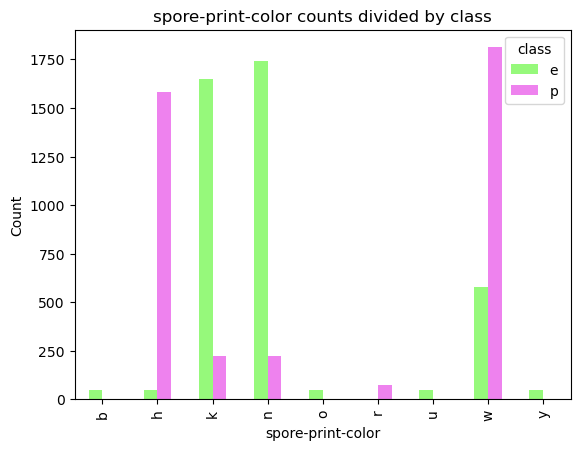

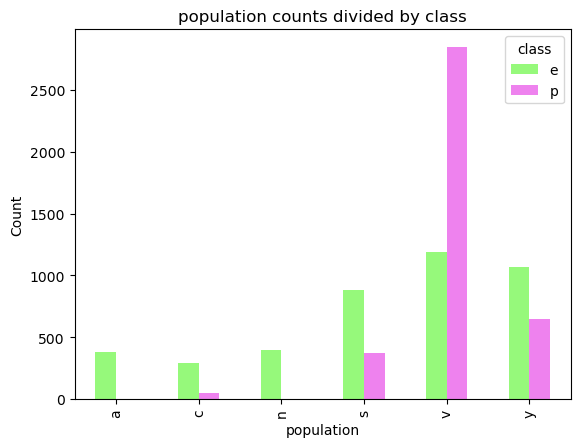

In [27]:
for feature in important_features:
    counts = df.groupby(feature)["class"].value_counts().unstack()
    
    ax = counts.plot(kind="bar", color=[colors[c] for c in counts.columns])
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.set_title(f'{feature} counts divided by class')
    plt.show()

We can see that all these features have values that are well separeted in the two classes.

Finally let's evaluate our system on the test set:

In [28]:
from sklearn.metrics import recall_score,precision_score, accuracy_score

y_pred = final_model.predict(X_test)
print(recall_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

1.0
1.0
1.0


**We achieve a perfect prediction.**